In [1]:
# Import some standard/utility libraries:
import os, sys, time, h5py, zipfile
import six           # six provides python 2/3 compatibility

# Import our numerical/scientific libraries, scipy and numpy, pandas:
import numpy as np
import scipy as sp
import pandas as pd

# The pimms (Python Immutables) library is a utility library that enables lazy
# computation and immutble data structures; https://github.com/noahbenson/pimms
import pimms

# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
# We also use the 3D graphics library ipyvolume for 3D surface rendering
import ipyvolume as ipv

In [2]:
# These "magic commands" tell matplotlib that we want to plot figures inline and
# That we are using qt as a backend; due to bugs in certain versions of
# matplotlib, we put them in a separate cell from the import statements above
# and the configuration statements below.
%gui qt
%matplotlib inline

In [3]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['Helvetica Neue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

In [4]:
# Check that HCP credentials were found:
if ny.config['hcp_credentials'] is None:
    raise Exception('No valid HCP credentials were found!\n'
                    'See above instructions for remedy.')

# Check that we can access the HCP database:
# To do this we grab the 's3fs' object from neuropythy's 'hcp' dataset; this
# object maintains a connection to Amazon's S3 using the hcp credentials. We use
# it to perform a basic ls operation on the S3 filesystem. If this fails, we do
# not have a working connection to the S3.
try: files = ny.data['hcp'].s3fs.ls('hcp-openaccess')
except Exception: files = None
if files is None:
    raise Exception('Could not communicate with S3!\n'
                    'This probably indicates that your credentials are wrong'
                    ' or that you do not have an internet connection.')

print('Configuration appears fine!')

Configuration appears fine!


In [5]:
def load_data(sid, h):
    sub = ny.hcp_subject(sid)
    # We will use one of the subject's hemisphere's (eigher lh or rh).
    # Get this hemisphere object from the subject object.
    hemi = sub.hemis[h]
    # We don't need the whole hemisphere; just the rear occipital hemisphere.
    fmap = ny.to_flatmap('occipital_pole', hemi)
    (u,v) = E = fmap.tess.indexed_edges
    rdat  = ny.retinotopy_data(fmap, 'prf_')
    # Convert the retinotopy data to (x,y) coordinates.
    (x,y) = ny.as_retinotopy(rdat, 'geographical')
    # We will want to look at the angle as well.
    angle = np.arctan2(y, x)
    # We typically store polar angle as degrees of clockwise rotation
    # starting at the positive y-axis.
    angle = 90 - 180/np.pi * angle
    angle = np.mod(angle + 180, 360) - 180
    path = os.path.join('visual_area_labels', '%s.%d_varea.mgz' % (h, sid))
    if os.path.isfile(path):
        true_labels = ny.load(path)
        label = true_labels[fmap.labels]
        return fmap, label, u, v, angle
    else:
        return None, None, None, None, None

In [6]:
# Plot the result of the above steps:
boundary_colors = {(1,2): (1,0,0), (0,1): (0.5,0,0),
                   (2,3): (0,1,0), (0,2): (0,0.5,0),
                   (0,3): (0,0,1)}
def generate_image_data(fmap, label, u, v, angle, boundary_colors, h):
    boundary = label[u] != label[v]
    boundary_u = u[boundary]
    boundary_v = v[boundary]
    boundary_lbl = [tuple(sorted([label[uu], label[vv]]))
                    for (uu,vv) in zip(boundary_u, boundary_v)]
    boundary_clr = [boundary_colors[lbl] for lbl in boundary_lbl]
    boundary_coords = np.mean([fmap.coordinates[:,boundary_u],
                               fmap.coordinates[:,boundary_v]],
                              axis=0)

    # Setup the matplotlib/pyplot figure.
    (fig1,axs) = plt.subplots(1,1, figsize=(14/9,14/9), dpi=144)
    fig1.subplots_adjust(0,0,1,1,0,0)

    ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs,
                   cmap='polar_angle', vmin=-180, vmax=180)
    plt.xlim(-80, 80)
    plt.ylim(-80, 80)
    axs.axis('off')
    fig1.savefig('pytorch-unet/data/val/image/'+str(sid)+'_'+str(h)+'_224.png', dpi=fig1.dpi)
    
#     (fig2,axs) = plt.subplots(1,1, figsize=(3,3), dpi=144)
#     fig2.subplots_adjust(0,0,1,1,0,0)
#     plt.xlim(-80, 80)
#     plt.ylim(-80, 80)
#     axs.axis('off')
#     axs.scatter(boundary_coords[0], boundary_coords[1], c='k', s=0.5)
    #fig2.savefig('pytorch-unet/data/train/mask/'+str(sid)+'_'+str(h)+'_.png', dpi=fig2.dpi)

    (fig3,axs) = plt.subplots(1,1, figsize=(14/9,14/9), dpi=144)
    fig3.subplots_adjust(0,0,1,1,0,0)
    mask = (label, (1,2,3))
    ny.cortex_plot(fmap, underlay='1.0', color=label, axes=axs,
               cmap=ny.graphics.label_cmap(label), mask=mask)
    plt.xlim(-80, 80)
    plt.ylim(-80, 80)
    axs.axis('off')
    fig3.savefig('pytorch-unet/data/val/mask/'+str(sid)+'_'+str(h)+'_segment_224.png', dpi=fig3.dpi)

/home/sc6995/.conda/envs/autolabel/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


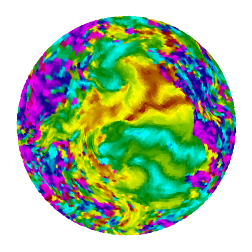

In [16]:
# trn_sids = ny.load('training_sids.json')
# sid = trn_sids[1]
# h = 'lh'
# fmap, label, u, v, angle = load_data(sid, h)
# if label is not None:
#     generate_image_data(fmap, label, u, v, angle, boundary_colors, h)

In [ ]:
trn_sids = ny.load('training_sids.json')
i=0
for sid in trn_sids:
    for h in ['lh', 'rh']:
        fmap, label, u, v, angle = load_data(sid, h)
        if label is not None:
            generate_image_data(fmap, label, u, v, angle, boundary_colors, h)
    print(i)
    i+=1

In [ ]:
trn_sids = ny.load('validate_sids.json')
i = 0
for sid in trn_sids:
    for h in ['lh', 'rh']:
        fmap, label, u, v, angle = load_data(sid, h)
        if label is not None:
            generate_image_data(fmap, label, u, v, angle, boundary_colors, h)
    print(i)
    i+=1